# 14. From a deterministic to a statistical model

## Numerical experiments - Week 17/2025

_Boyan Mihaylov, MSc Computational Science (UVA/VU)_

Spores are inherently heterogeneous, exhibiting a variation in their size and physiology, which affects their characteristic inhibitor release time, initial concentration and threshold of germination inhibition. This results in empirical experiments observing a gradual change in the germination percentage under changing environmental conditions, instead of a binary switch from a fully germinated to a fully non-germinated inoculum. This notebook attempts to address the statistical distributions of the different parameters in the established analytical formula, so that the model can be fitted to existing experimental data.

## Prerequisite libraries

In [1]:
using QuadGK
using LsqFit
using Optim
using BlackBoxOptim
using SpecialFunctions
using Distributions
using PyPlot
using DataFrames
using CSV
using Revise

Revise.includet("./conversions.jl")
Revise.includet("./diffusion.jl")
Revise.includet("./setup.jl")
Revise.includet("./plotting.jl")
Revise.includet("./analysis.jl")
using .Conversions
using .Diffusion
using .Setup
using .Plotting
using .Analysis

## 1. Derivation of germination success rate

The inhibitor release model developed so far follows the formula

$$
\begin{equation}
c_{\textrm{in}}{(t)}=\phi c_0+(1-\phi)\left[c_{\textrm{ex}}+\left(c_0-c_{\textrm{ex}}\right)e^{-\frac{t}{\tau(1-\phi)}}\right],
\end{equation}
$$

where

$$
\begin{equation}
\tau=\frac{V_s}{P_sA}
\end{equation}
$$

is the characteristic relaxation time dependent on the ratio of the surface $A$ and the volume $V_s$ of the spore, and on the permeation coefficient $P_s$. The volume fraction $\phi=\rho_sV_s$ is a dimensionless measure dependent on the spore number density $\rho_s$. Some basic assumptions can be made about the variables in this model:

- Each spore is approximately spherical, so the surface-to-volume ratio can be expressed through the spore radius $R$: $\frac{V_s}{A}\approx \frac{\frac{4}{3}\pi R^3}{4\pi R}=\frac{R}{3}$. The radius can be modelled by a random variable $\xi$.
- The spore density can be considered a constant, so the volume fraction $\phi$ varies only depending on the radius via the spore volume.
- The permeation coefficient is a quantity derived from statistical mechanics, so it is considered a constant.
- The initial concentration $c_0$ and the concentration threshold $c_T$ for germination inhibition vary randomly.

In the absence of an exogenously added external inhibitor, the inhibitor loses its effect once its concentration reaches the concentration threshold at an observed time for germination $t_{\textrm{germ}}$:

$$
\begin{equation}
c_{\textrm{in}}{(t_{\textrm{germ}})}=\phi c_0+(1-\phi)c_0e^{-\frac{t_{\textrm{germ}}}{\tau(1-\phi)}}=c_T.
\end{equation}
$$

In reality, the onset of germination can be observed at slightly varying times, but this randomness can be absorbed by the threshold variable $c_T$. Thus, expressing

$$
\begin{equation}
c_{\textrm{in}}{(t_{\textrm{germ}})}=\beta c_0,
\end{equation}
$$

where $\beta=\phi+(1-\phi)e^{-\frac{t_{\textrm{germ}}}{\tau(1-\phi)}}$, and

$$
\begin{equation}
c_T=\gamma c_0,
\end{equation}
$$

where $\gamma$ is a random variable with an unknown distribution, one can express the condition for germination as

$$
\begin{equation}
\beta c_0<\gamma c_0,
\end{equation}
$$

or, simplified,

$$
\begin{equation}
\beta{(\xi, \rho_s)}<\gamma,
\end{equation}
$$

where $\beta$ is expressed as a function of $\xi$ and $\rho_s$. When changing the main control parameter of the model, the spore density $\rho_s$, the percentage of germinated spores is expressed through the probability

$$
\begin{equation}
p{(\rho_s)}=P{(\beta<\gamma\ |\ \rho_s)}.
\end{equation}
$$

Accounting for the distribution of $\xi$,

$$
\begin{equation}
p{(\rho_s)}=\int_0^\infty{P{(\beta<\gamma\ |\ \rho_s, \xi)}\ f_\xi{(\xi)}\ d{\xi}},
\end{equation}
$$

where $f_\xi{(\xi)}$ is the probability distribution funciton (PDF) for the spore radius. For simplicity, it can be assumed that $\gamma$ and $\xi$ are normally distributed. Then, following the standard normal cumulative distribution function (CDF) of $\gamma$, $\Phi{\left(\frac{\beta-\mu_\gamma}{\sigma_\gamma}\right)}$,

$$
\begin{equation}
P{(\beta<\gamma\ |\ \rho_s, \xi)}=1-\Phi{\left(\frac{\beta{(\xi)}-\mu_\gamma}{\sigma_\gamma}\right)}.
\end{equation}
$$

The PDF of $\xi$ is then the Gaussian function

$$
\begin{equation}
f_\xi{(\xi)}=\frac{1}{\sqrt{2\pi}\sigma_\xi}\exp{\left(-\frac{(\xi-\mu_\xi)}{2\sigma_\xi^2}\right)}.
\end{equation}
$$

Thus, the germination probability can be expressed as

$$
\begin{equation}
p{(\rho_s)}=\int_0^\infty{\left[1-\Phi{\left(\frac{\beta{(\xi)}-\mu_\gamma}{\sigma_\gamma}\right)}\right]\ \frac{1}{\sqrt{2\pi}\sigma_\xi}\exp{\left(-\frac{(\xi-\mu_\xi)^2}{2\sigma_\xi^2}\right)}\ d{\xi}}.
\end{equation}
$$

The mean and standard deviation of the spore radius can be inferred from literature. For instance, the diameter of _A. niger_ has $\mu_\xi=5.3\ \mu\textrm{m}$ and $\sigma_\xi=0.6\ \mu\textrm{m}$ [1], while the diameter of _A. nidulans_ is observed to vary between $2.4$ and $2.7\ \mu\textrm{m}$. Thus, in the latter case it can be assumed that $\mu_\xi=1.275\ \mu\textrm{m}$ and $\sigma_\xi=0.075\ \mu\textrm{m}$.

## 2. Fitting the model to experimental data

### 2.1. Parameter estimation on data from density-driven germination (Herrero-Garcia et al.)

The free parameters in the model are $\mu_\gamma$, $\sigma_\gamma$ and $P_s$. Using the experimental data from Herrero-Garcia et al. [3], the spore density $\rho_s$ can be used as input variable for matching the germination responses. A non-linear optimisation process using `BlackBoxOptim.jl` is applied to find the appropriate parameter values.

0.7934415835678857
Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
8.32 secs, 1381 evals, 1272 steps, improv/step: 0.299 (last = 0.2987), fitness=0.664993090
16.14 secs, 1439 evals, 1330 steps, improv/step: 0.295 (last = 0.2069), fitness=0.664993090
19.86 secs, 1678 evals, 1569 steps, improv/step: 0.291 (last = 0.2678), fitness=0.465774797
26.80 secs, 1807 evals, 1699 steps, improv/step: 0.289 (last = 0.2692), fitness=0.465774797
30.13 secs, 2622 evals, 2516 steps, improv/step: 0.288 (last = 0.2852), fitness=0.029668257
30.63 secs, 4053 evals, 3947 steps, improv/step: 0.298 (last = 0.3166), fitness=0.021731438
31.13 secs, 6389 evals, 6283 steps, improv/step: 0.274 (last = 0.2324), fitness=0.021530300
31.64 secs, 9101 evals, 8996 steps, improv/step: 0.261 (last = 0.2300), fitness=0.020951525

Optimization stopped after 10001 steps an

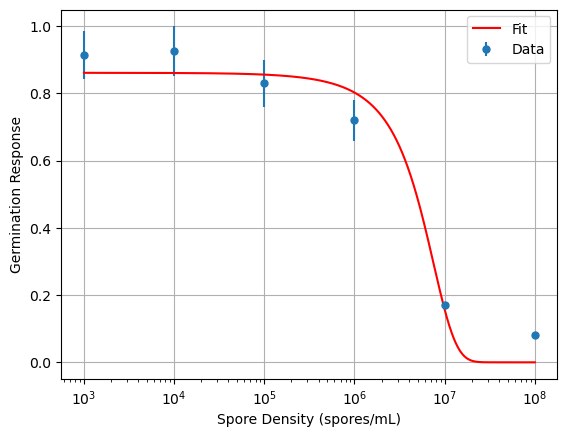

In [7]:
function germination_response(ρ, Pₛ, μ_γ, σ_γ, μ_ξ, σ_ξ, t)
    """
    Compute the germination_response for a given set of parameters.
    inputs:
        ρ - spore density in spores/mL
        μ_γ - mean inhibition threshold
        σ_γ - standard deviation of inhibition threshold
        μ_ξ - mean spore radius in um
        σ_ξ - standard deviation of spore radius in um
        Pₛ - permeation constant in um/s
        t - time
    output:
        germination_response - the germination response for the given parameters
    """

    # Convert units
    ρ = inverse_mL_to_cubic_um(ρ) # Convert from spores/mL to spores/m^3
    
    function integrand(ξ)
        dist_ξ = truncated(Normal(μ_ξ, σ_ξ), 0.0, Inf)
        V = 4/3 * π .* ξ^3
        A = 4 * π .* ξ^2
        τ = V ./ (Pₛ * A)
        ϕ = ρ .* V
        β = ϕ .+ (1 .- ϕ) .* exp.(-t ./ (τ .* (1 .- ϕ)))
        z = (β .- μ_γ) ./ σ_γ
        Φ = 0.5 .* (1 .+ erf.(z ./ √2))
        return (1 .- Φ) .* pdf(dist_ξ, ξ)
    end

    return quadgk(x -> integrand(x), 0.0, Inf, rtol=1e-8)[1]
end

# Constants
μ_ξ = 1.275
σ_ξ = 0.075
t = 36000 # 10 hours in seconds

# Model wrapper
wrapper(ρ_exp, params) = germination_response(10 .^ ρ_exp, 10 .^ (-params[1]), params[2], params[3], μ_ξ, σ_ξ, t)

println(wrapper(5, [3, 1e-6, 1e-8]))

# spore_densities = [1e3, 1e4, 1e5, 1e6, 1e7, 1e8]
spore_density_exponents = collect(3:8)
germination_responses = [0.913, 0.925, 0.83, 0.72, 0.17, 0.08]
confidence_intervals = [0.071, 0.074, 0.07, 0.061, 0.003, 0.003]

# Initial guesses and bounds for the parameters
p0 = [3, 1e-6, 1e-8] # Initial guess for Pₛ, μ_γ, σ_γ
lower_bounds = [2, 1e-10, 1e-12]
upper_bounds = [5, 1.0, 0.1]

# Define a scalar objective: sum of squared errors
function obj(params)
    ŷ = wrapper.(spore_density_exponents, Ref(params))
    return sum(abs2, ŷ .- germination_responses)
end

bounds = [(lb, ub) for (lb, ub) in zip(lower_bounds, upper_bounds)]
res = bboptimize(params -> obj(params);
                 SearchRange = bounds,
                 NumDimensions = 3,
                 MaxSteps = 10000)
p_opt = best_candidate(res)

# wrapper(1e4, [1e-2, 2e-6, 0.0])

Pₛ_fit = 10 .^ (-p_opt[1])
μ_γ_fit = p_opt[2]
σ_γ_fit = p_opt[3]

println("Optimized parameters:")
println("Pₛ: ", Pₛ_fit)
println("μ_γ: ", μ_γ_fit)
println("σ_γ: ", σ_γ_fit)

# Plot data and fit
fig, ax = plt.subplots()
ax.errorbar(10 .^ spore_density_exponents, germination_responses, yerr=confidence_intervals, fmt="o", markersize=5, label="Data")
sample_exp = LinRange(3, 8, 5000)
fit_responses = [wrapper(exponent, p_opt) for exponent in sample_exp]
ax.plot(10 .^ sample_exp, fit_responses, label="Fit", color="red")
ax.set_xscale("log")
ax.set_xlabel("Spore Density (spores/mL)")
ax.set_ylabel("Germination Response")
ax.grid()
ax.legend()

gcf()

The fitted model closely resembles the experimental data, mostly in capturing the transition from full germination to no germination as $\rho_s$ increases from $10^5$ to $10^7$. The fitted concenration reduction is $6.5\times 10^{-5}\pm 3.6\times 10^{-5}$, encompassing a rather borad interval of concentration thresholds $c_T=\gamma c_0$ from $\mathcal{O}{(10^{-10})}\ \textrm{M}$ to a very slight decrease, still within the order of $10^{-5}\ \textrm{M}$. The fitted permeation constant is $P_s\approx 1.3\times10^{-4}\ \mu\textrm{m/s}$, close to the lower limit of observed permeabilities.

### 2.2. Testing the parameters on data from exogenously driven inhibition

The estimated parameters are used in an attempt to reproduce the data from the second experiment of Herrero-Garcia et al. [3], using different inputs for $c_{\textrm{ex}}$. To this end, the germination probability needs to be redefined in the presence of an exogenously added inhibitor. Rewriting the concentration formula,

$$
\begin{equation}
c_{\textrm{in}}{(t)}=\left[\phi+(1-\phi)e^{-\frac{t}{\tau(1-\phi)}}\right] c_0+(1-\phi)\left(1-e^{-\frac{t}{\tau(1-\phi)}}\right)c_{\textrm{ex}},
\end{equation}
$$

one can define $\beta=\phi+(1-\phi)e^{-\frac{t}{\tau(1-\phi)}}$ and $\chi=(1-\phi)\left(1-e^{-\frac{t}{\tau(1-\phi)}}\right)$, such that the condition for germination becomes

$$
\begin{equation}
\beta c_0 + \chi c_{\textrm{ex}}<\gamma c_0.
\end{equation}
$$

This time it is not possible to cancel the variable $c_0$ on both sides of the equation, so the potential spore-specific variation in the initial inhibitor concentration needs to be accounted for. $c_0$ can be represented by another random variable, $\psi$, which can also be assumed normally distributed, for simplicity. The above formula can be rewritten to

$$
\begin{equation}
\beta + \chi \frac{c_{\textrm{ex}}}{\psi}<\gamma,
\end{equation}
$$

resulting in the probability

$$
\begin{equation}
P{\left(\beta + \chi \frac{c_{\textrm{ex}}}{\psi}<\gamma\ |\ \xi, \psi\right)}=1-\Phi{\left(\frac{\beta{(\xi)} + \chi \frac{c_{\textrm{ex}}}{\psi}-\mu_\gamma}{\sigma_\gamma}\right)}.
\end{equation}
$$

This time, the probability for germination is an integral over the possible spore radii and initial inhibitor loads:

$$
\begin{equation}
p{(\rho_s, c_{\textrm{ex}})}=\int_0^\infty{\int_0^\infty{\left[1-\Phi{\left(\frac{\beta{(\xi)} + \chi \frac{c_{\textrm{ex}}}{\psi}-\mu_\gamma}{\sigma_\gamma}\right)}\right]f_\psi{(\psi)}\ f_\xi{(\xi)}\ d{\psi}}\ d{\xi}},
\end{equation}
$$

where the two PDFs are

$$
\begin{equation}
f_\psi{(\psi)} = \frac{1}{\sqrt{2\pi}\sigma_\psi}e^{-\frac{(\psi-\mu_\psi)^2}{2\sigma_\psi^2}},
\end{equation}
$$

$$
\begin{equation}
f_\xi{(\xi)} = \frac{1}{\sqrt{2\pi}\sigma_\xi}e^{-\frac{(\xi-\mu_\xi)^2}{2\sigma_\xi^2}}.
\end{equation}
$$

The only unknown parameters in this model are $\mu_\psi$ and $\sigma_\psi$, so an attempt can be made to fit them given the known and previously estimated remaining parameters.

1.4419486517230064e-9
Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.50 secs, 6222 evals, 6173 steps, improv/step: 1.000 (last = 0.9998), fitness=0.906200000

Optimization stopped after 10001 steps and 0.79 seconds
Termination reason: Max number of steps (10000) reached
Steps per second = 12595.72
Function evals per second = 12656.17
Improvements/step = 0.99990
Total function evaluations = 10049


Best candidate found: [0.821106, 0.042363]

Fitness: 0.906200000

Optimized parameters:
μ_ψ: 0.8211059316525939
σ_ψ: 0.042363013169612655


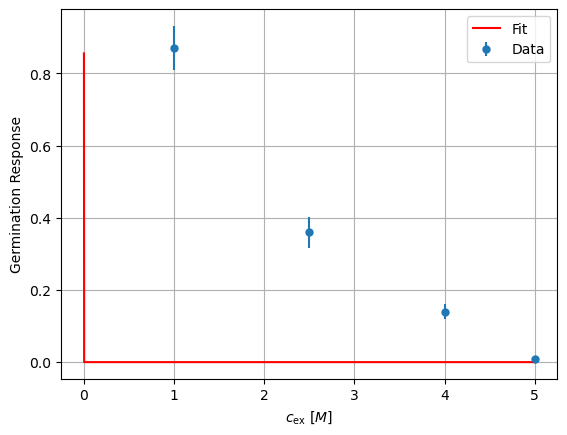

In [8]:
function germination_response_c_ex(c_ex, μ_ψ, σ_ψ, μ_γ, σ_γ, μ_ξ, σ_ξ, Pₛ, ρ, t)
    """
    Compute the germination_response for a given set of parameters.
    inputs:
        c_ex - exogenously added concentration in M
        μ_ψ - mean initial concentration
        σ_ψ - standard deviation of initial concentration
        μ_γ - mean inhibition threshold
        σ_γ - standard deviation of inhibition threshold
        μ_ξ - mean spore radius in um
        σ_ξ - standard deviation of spore radius in um
        Pₛ - permeation constant in um/s
        ρ - spore density in spores/mL
        t - time
    output:
        germination_response - the germination response for the given parameters
    """

    # Convert units
    ρ = inverse_mL_to_cubic_um(ρ) # Convert from spores/mL to spores/m^3
    
    function integrand_xi(ξ)

        dist_ξ = truncated(Normal(μ_ξ, σ_ξ), 0.0, Inf)

        V = 4/3 * π .* ξ^3
        A = 4 * π .* ξ^2
        τ = V ./ (Pₛ * A)
        ϕ = ρ .* V
        β = ϕ .+ (1 .- ϕ) .* exp.(-t ./ (τ .* (1 .- ϕ)))
        χ = (1 .- ϕ) .* (1 .- exp.(-t ./ (τ .* (1 .- ϕ))))

        function integrand_psi(ψ)
            dist_ψ = truncated(Normal(μ_ψ, σ_ψ), 0.0, Inf)
            z = (β .+ χ .* c_ex ./ ψ .- μ_γ) ./ σ_γ
            # z = (β .- μ_γ) ./ σ_γ
            Φ = 0.5 .* (1 .+ erf.(z ./ √2))
            return (1 .- Φ) .* pdf(dist_ψ, ψ)
        end

        ψ_lo = max(0.0, μ_ψ - 6σ_ψ)
        ψ_hi = μ_ψ + 6σ_ψ
        
        return quadgk(x -> integrand_psi(x), ψ_lo, ψ_hi, rtol=1e-8)[1] .* pdf(dist_ξ, ξ)
    end

    return quadgk(x -> integrand_xi(x), 0.0, Inf, rtol=1e-8)[1]
end

# Constants
ρ = 1e5 # spore density in spores/mL

# Model wrapper
wrapper2(c_ex, params) = germination_response_c_ex(c_ex, params[1], params[2], μ_γ_fit, σ_γ_fit, μ_ξ, σ_ξ, Pₛ_fit, ρ, t)

println(wrapper2(0.00000001, [1e-5, 1e-5]))

concentrations = [1.0, 2.5, 4.0, 5.0]
germination_responses = [0.87, 0.36, 0.14, 0.01]
confidence_intervals = [0.061, 0.043, 0.021, 0.003]

# Initial guesses and bounds for the parameters
p0 = [1e-2, 1e-8] # Initial guess for μ_ψ, σ_ψ
lower_bounds = [1e-10, 1e-12]
upper_bounds = [1.0, 0.1]

# Define a scalar objective: sum of squared errors
function obj(params)
    ŷ = wrapper2.(concentrations, Ref(params))
    return sum(abs2, ŷ .- germination_responses)
end

# res_nm = optimize(obj, p0, NelderMead(); 
#                   lower=lower_bounds, upper=upper_bounds,
#                   options=Optim.Options(iterations=10000))
bounds = [(lb, ub) for (lb, ub) in zip(lower_bounds, upper_bounds)]
res = bboptimize(params -> obj(params);
                 SearchRange = bounds,
                 NumDimensions = 2,
                 MaxSteps = 10000)
p_opt = best_candidate(res)

μ_ψ_fit = p_opt[1]
σ_ψ_fit = p_opt[2]

println("Optimized parameters:")
println("μ_ψ: ", μ_ψ_fit)
println("σ_ψ: ", σ_ψ_fit)

# Plot data and fit
fig, ax = plt.subplots()
ax.errorbar(concentrations, germination_responses, yerr=confidence_intervals, fmt="o", markersize=5, label="Data")
samples = LinRange(0.0, 5.0, 5000)
fit_responses = [wrapper2(samp, p_opt) for samp in samples]
ax.plot(samples, fit_responses, label="Fit", color="red")
ax.set_xlabel(L"c_{\text{ex}}\ [M]")
ax.set_ylabel("Germination Response")
ax.grid()
ax.legend()

gcf()

Even after extensive optimisation, the simulated germination response under varying $c_{\textrm{ex}}$ does not match the experimental data: the germination probability drops to zero as soon as a tiny amount of $c_{\textrm{ex}}$ is added. This could be an indication that the inhibition in the density-driven scenario is not based solely on 1-octen-3-ol, as is the case in the second experiment.

### 2.3. Fitting the model on combined experimental data

To investigate whether there is a scenario in which a density-driven and an exogenously driven inhibition can be explained by the same model, one more optimisation procedure is performed, this time using a combined data set from both experiments - including both $\rho_s$ and $c_{\textrm{ex}}$. This means that 5 parameters need to be estimated: $P_s$, $\mu_\gamma$, $\sigma_\gamma$, $\mu_\psi$ and $\sigma_\psi$.

In [5]:
function germination_response_combined(ρ, c_ex, Pₛ, μ_ψ, σ_ψ, μ_γ, σ_γ, μ_ξ, σ_ξ, t)
    """
    Compute the germination_response for a given set of parameters.
    inputs:
        ρ - spore density in spores/mL
        c_ex - exogenously added concentration in M
        Pₛ - permeation constant in um/s
        μ_ψ - mean initial concentration
        σ_ψ - standard deviation of initial concentration
        μ_γ - mean inhibition threshold
        σ_γ - standard deviation of inhibition threshold
        μ_ξ - mean spore radius in um
        σ_ξ - standard deviation of spore radius in um
        t - time
    output:
        germination_response - the germination response for the given parameters
    """

    # Convert units
    ρ = inverse_mL_to_cubic_um(ρ) # Convert from spores/mL to spores/m^3
    
    function integrand_xi(ξ)

        dist_ξ = truncated(Normal(μ_ξ, σ_ξ), 0.0, Inf)

        V = 4/3 * π .* ξ^3
        A = 4 * π .* ξ^2
        τ = V ./ (Pₛ * A)
        ϕ = ρ .* V
        β = ϕ .+ (1 .- ϕ) .* exp.(-t ./ (τ .* (1 .- ϕ)))
        χ = (1 .- ϕ) .* (1 .- exp.(-t ./ (τ .* (1 .- ϕ))))

        function integrand_psi(ψ)
            dist_ψ = truncated(Normal(μ_ψ, σ_ψ), 0.0, Inf)
            z = (β .+ χ .* c_ex ./ ψ .- μ_γ) ./ σ_γ
            Φ = 0.5 .* (1 .+ erf.(z ./ √2))
            return (1 .- Φ) .* pdf(dist_ψ, ψ)
        end

        ψ_lo = max(0.0, μ_ψ - 6σ_ψ)
        ψ_hi = μ_ψ + 6σ_ψ
        
        return quadgk(x -> integrand_psi(x), ψ_lo, ψ_hi, rtol=1e-8)[1] .* pdf(dist_ξ, ξ)
    end

    return quadgk(x -> integrand_xi(x), 0.0, Inf, rtol=1e-8)[1]
end

# Constants
μ_ξ = 1.275
σ_ξ = 0.075
t = 36000 # 10 hours in seconds

# Model wrapper
wrapper3(input, params) = germination_response_combined(input[1], input[2], params[1], params[2], params[3], params[4], params[5], μ_ξ, σ_ξ, t)

println(wrapper3([5, 0.00000001], [3, 1e-6, 1e-8, 1e-5, 1e-5]))

spore_density_exponents = [3, 4, 5, 6, 7, 8, 5, 5, 5, 5]
concentrations = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.5, 4.0, 5.0]
germination_responses = [0.913, 0.925, 0.83, 0.72, 0.17, 0.08, 0.87, 0.36, 0.14, 0.01]
confidence_intervals = [0.071, 0.074, 0.07, 0.061, 0.003, 0.003, 0.061, 0.043, 0.021, 0.003]

inputs = collect(zip(spore_density_exponents, concentrations))
println("Inputs: ", inputs)

# Bounds for the parameters
lower_bounds = [2, 1e-10, 1e-12, 1e-10, 1e-12]
upper_bounds = [5, 1.0, 0.1, 1.0, 0.1]

# Define a scalar objective: sum of squared errors
function obj(params)
    ŷ = wrapper3.(inputs, Ref(params))
    return sum(abs2, ŷ .- germination_responses)
end

bounds = [(lb, ub) for (lb, ub) in zip(lower_bounds, upper_bounds)]
res = bboptimize(params -> obj(params);
                 SearchRange = bounds,
                 NumDimensions = 5,
                 MaxSteps = 100)
p_opt = best_candidate(res)

Pₛ_fit = 10 .^ (-p_opt[1])
μ_γ_fit = p_opt[2]
σ_γ_fit = p_opt[3]
μ_ψ_fit = p_opt[4]
σ_ψ_fit = p_opt[5]

println("Optimized parameters:")
println("Pₛ: ", Pₛ_fit)
println("μ_γ: ", μ_γ_fit)
println("σ_γ: ", σ_γ_fit)
println("μ_ψ: ", μ_ψ_fit)
println("σ_ψ: ", σ_ψ_fit)

0.0
Inputs: [(3, 0.0), (4, 0.0), (5, 0.0), (6, 0.0), (7, 0.0), (8, 0.0), (5, 1.0), (5, 2.5), (5, 4.0), (5, 5.0)]
Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
7.21 secs, 12 evals, 6 steps, improv/step: 0.500 (last = 0.5000), fitness=2.113644639
215.38 secs, 21 evals, 11 steps, improv/step: 0.455 (last = 0.4000), fitness=1.816571241
275.03 secs, 25 evals, 13 steps, improv/step: 0.385 (last = 0.0000), fitness=1.816571241
581.99 secs, 27 evals, 14 steps, improv/step: 0.357 (last = 0.0000), fitness=1.816571241
1381.59 secs, 29 evals, 15 steps, improv/step: 0.333 (last = 0.0000), fitness=1.816571241
1995.95 secs, 35 evals, 18 steps, improv/step: 0.278 (last = 0.0000), fitness=1.816571241
1996.50 secs, 49 evals, 25 steps, improv/step: 0.360 (last = 0.5714), fitness=1.816571241
2450.72 secs, 60 evals, 31 steps, improv/step: 0.419 (last =

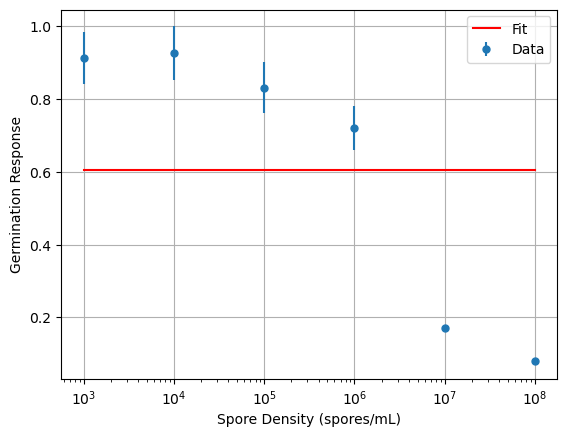

In [11]:
# Plot data and fit
fig, ax = plt.subplots()
ax.errorbar(10 .^ spore_density_exponents[1:6], germination_responses[1:6], yerr=confidence_intervals[1:6], fmt="o", markersize=5, label="Data")
sample_density_exponents = LinRange(3, 8, 1000)
fit_responses = [wrapper3([exponent, 0.0], p_opt) for exponent in sample_density_exponents]
ax.plot(10 .^ sample_density_exponents, fit_responses, label="Fit", color="red")
ax.set_xscale("log")
ax.set_xlabel("Spore Density (spores/mL)")
ax.set_ylabel("Germination Response")
ax.grid()
ax.legend()

gcf()

In [ ]:
# Plot data and fit
fig, ax = plt.subplots()
ax.errorbar(concentrations[7:end], germination_responses[7:end], yerr=confidence_intervals[7:end], fmt="o", markersize=5, label="Data")
sample_c_ex = collect(LinRange(0.0, 5.0, 100))
fit_responses = [wrapper3([5, samp], p_opt) for samp in sample_c_ex]
ax.plot(sample_c_ex, fit_responses, label="Fit", color="red")
ax.set_xlabel(L"c_{\text{ex}}\ [M]")
ax.set_ylabel("Germination Response")
ax.grid()
ax.legend()

gcf()

The optimisation fails to produce a good fit for both data sets simultaneously, reinforcing the conclusion that the underlying mechanisms for the two results are fundamentally different.

### 2.4. Parameter estimation on data from density-driven germination (Ijadpanahsaravi et al.)

Another available data set is from Ijadpanahsaravi et al. [4] and contains the germination response for different inoculum densities of _A. niger_. An attempt is made to fit the model to this data and to investigate to what degree the parameters are consistent with the previous case. The three types of germination-inducing medium (alanine, arginine and proline) are thereby considered separately.

First, the data is parsed.

In [2]:
df_germination = DataFrame(CSV.File("Data/swelling_germination_results.csv"; header=true))
df_germination_extremes = DataFrame(CSV.File("Data/swelling_germination_results_extreme_densities.csv"))

# ===== Filter data from germination with many densities =====

# Filter the data to only include swelling
df_germination_swelling = filter(row -> row[1] == "Swelling", df_germination)

# Expression for parsing
regex_triplet = r"(-?\d+\.\d+)\[(-?\d+\.\d+);(-?\d+\.\d+)\]*.*"

# Function to parse a string and return three numbers
function parse_numbers(s)
    m = match(regex_triplet, s)
    if m !== nothing
        num1 = parse(Float64, m.captures[1])
        num2 = parse(Float64, m.captures[2])
        num3 = parse(Float64, m.captures[3])
        return num1, num2, num3
    else
        return missing, missing, missing
    end
end

# Parse Pmax and its confidence intervals
Pmax_parsed = [parse_numbers(row[1]) for row in eachrow(df_germination_swelling[!, 4])]
Pmax_vals = [x[1] for x in Pmax_parsed]
PmaxCIlow_vals = [x[2] for x in Pmax_parsed]
PmaxCIhigh_vals = [x[3] for x in Pmax_parsed]

# Parse tau and its confidence intervals
tau_parsed = [parse_numbers(row[1]) for row in eachrow(df_germination_swelling[!, 5])]
tau_vals = [x[1] for x in tau_parsed]
tauCIlow_vals = [x[2] for x in tau_parsed]
tauCIhigh_vals = [x[3] for x in tau_parsed]

# Reconstruct the DataFrame with the parsed values
df_germination_rebuilt = DataFrame(
    :CarbonSource => df_germination_swelling[!, 2],
    :Density => inverse_uL_to_mL(df_germination_swelling[!, 3] / 150),
    :Pmax => Pmax_vals,
    :Pmax_CI_Lower => PmaxCIlow_vals,
    :Pmax_CI_Upper => PmaxCIhigh_vals,
    :tau => tau_vals,
    :tau_CI_Lower => tauCIlow_vals,
    :tau_CI_Upper => tauCIhigh_vals,
    :N => df_germination_swelling[!, 8],
    :M => df_germination_swelling[!, 9]
)

# ===== Filter data from germination with extreme densities =====

# Find the first row that contains only missing values
first_missing_row_index = findfirst(row -> all(ismissing, row), eachrow(df_germination_extremes))

# Filter rows preceding the first row with all missing elements
if first_missing_row_index !== nothing
    preceding_rows = df_germination_extremes[1:first_missing_row_index-1, :]
else
    preceding_rows = df_germination_extremes
end

# Further filter these rows to include only those where the string in the first column starts with "A"
df_germination_extremes_swelling = filter(row -> startswith(row[1], "A"), preceding_rows)

# Parse density values
regex_single = r"\((\d+)\)"
function parse_density(s)
    m = match(regex_single, s)
    if m !== nothing
        return parse(Int, m.captures[1])
    else
        return missing
    end
end
density_vals = [inverse_uL_to_mL(parse_density(row[1])/150) for row in eachrow(df_germination_extremes_swelling)]

# Expression for parsing
regex_triplet = r"(-?\d+\.\d+) \[(-?\d+\.\d+);(-?\d+\.\d+)\]*.*"

# Parse Pmax and its confidence intervals
Pmax_parsed = [parse_numbers(row[3]) for row in eachrow(df_germination_extremes_swelling)]
Pmax_vals = [x[1] for x in Pmax_parsed]
PmaxCIlow_vals = [x[2] for x in Pmax_parsed]
PmaxCIhigh_vals = [x[3] for x in Pmax_parsed]

# Parse tau and its confidence intervals
tau_parsed = [parse_numbers(row[4]) for row in eachrow(df_germination_extremes_swelling)]
tau_vals = [x[1] for x in tau_parsed]
tauCIlow_vals = [x[2] for x in tau_parsed]
tauCIhigh_vals = [x[3] for x in tau_parsed]

# Reconstruct the DataFrame with the parsed values
df_germination_extremes_rebuilt = DataFrame(
    :CarbonSource => df_germination_extremes_swelling[!, 2],
    :Density => density_vals,
    :Pmax => Pmax_vals,
    :Pmax_CI_Lower => PmaxCIlow_vals,
    :Pmax_CI_Upper => PmaxCIhigh_vals,
    :tau => tau_vals,
    :tau_CI_Lower => tauCIlow_vals,
    :tau_CI_Upper => tauCIhigh_vals,
    :N => df_germination_extremes_swelling[!, 5],
    :M => df_germination_extremes_swelling[!, 6]
)

df_germination_rebuilt

Row,CarbonSource,Density,Pmax,Pmax_CI_Lower,Pmax_CI_Upper,tau,tau_CI_Lower,tau_CI_Upper,N,M
,String3,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64
1,Ala,33333.3,95.98,92.44,99.51,6.93,6.59,7.26,373,10
2,Ala,66666.7,90.81,86.43,95.18,5.28,4.84,5.72,979,37
3,Ala,1.33333e5,84.14,78.58,89.69,5.77,5.17,6.37,1112,66
4,Ala,2.66667e5,71.91,61.67,82.14,6.31,5.06,7.57,1301,89
5,Arg,33333.3,25.06,-0.83,50.96,15.0,1.47,28.53,626,94
6,Arg,66666.7,16.61,5.63,27.6,15.0,7.02,22.98,1026,19
7,Arg,1.33333e5,13.69,4.32,23.05,15.0,-0.44,30.44,1372,14
8,Arg,2.66667e5,11.25,-1.93,24.43,15.0,-12.95,42.95,1408,105
9,Pro,33333.3,94.95,91.22,98.69,4.55,4.19,4.91,526,7


For each type of medium, the optimisation procedure fits the parameters of the model. The corresponding radius ditribution for _A. niger_ conidia is used: $\mu_\xi=2.65\ \mu\textrm{m}$, $\sigma_\xi=0.3\ \mu\textrm{m}$. The optimised parameter configurations are plotted against the data.

5.9918304202075915e-6
Carbon source: Ala
Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.50 secs, 3892 evals, 3792 steps, improv/step: 0.240 (last = 0.2397), fitness=0.022560532
1.00 secs, 7721 evals, 7624 steps, improv/step: 0.238 (last = 0.2370), fitness=0.001184588
1.50 secs, 11777 evals, 11682 steps, improv/step: 0.229 (last = 0.2104), fitness=0.001087494
2.00 secs, 15361 evals, 15269 steps, improv/step: 0.219 (last = 0.1890), fitness=0.001087466
2.50 secs, 18981 evals, 18891 steps, improv/step: 0.213 (last = 0.1861), fitness=0.001087466
3.01 secs, 22378 evals, 22290 steps, improv/step: 0.192 (last = 0.0756), fitness=0.001087466
3.51 secs, 26098 evals, 26011 steps, improv/step: 0.167 (last = 0.0140), fitness=0.001087466
4.01 secs, 29681 evals, 29596 steps, improv/step: 0.148 (last = 0.0098), fitness=0.001087466

Optimization s

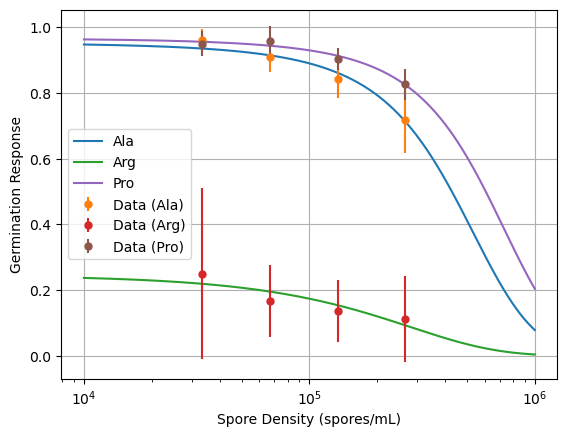

In [26]:
# Constants
μ_ξ = 2.65
σ_ξ = 0.3
t = 36000 # 10 hours in seconds

# Model wrapper
wrapper(ρ_exp, params) = germination_response(10 .^ ρ_exp, 10 .^ (-params[1]), params[2], params[3], μ_ξ, σ_ξ, t)

println(wrapper(5, [3, 1e-6, 1e-8]))

# Initial guesses and bounds for the parameters
p0 = [3, 1e-6, 1e-8] # Initial guess for Pₛ, μ_γ, σ_γ
lower_bounds = [2, 1e-10, 1e-12]
upper_bounds = [5, 1.0, 0.1]
bounds = [(lb, ub) for (lb, ub) in zip(lower_bounds, upper_bounds)]

fig, ax = plt.subplots()

carbon_srcs = unique(df_germination_rebuilt[!, :CarbonSource])
p_opt = zeros(length(carbon_srcs), 3)
spore_densities_all = []
sample_density_exp = LinRange(4, 6, 1000)
for (i, src) in enumerate(carbon_srcs)

    # Gather data
    println("Carbon source: ", src)
    df_src = filter(row -> row[:CarbonSource] == src, df_germination_rebuilt)
    spore_densities = df_src[!, :Density]
    spore_density_exponents = log10.(spore_densities)
    germination_responses = df_src[!, :Pmax] * 0.01

    # confidence_intervals
    err_lo = df_src[!, :Pmax]-df_src[!, :Pmax_CI_Lower]
    err_lo[err_lo .< 0] .= 0
    err_hi = df_src[!, :Pmax_CI_Upper]-df_src[!, :Pmax]
    err_lo = err_lo * 0.01
    err_hi = err_hi * 0.01

    push!(spore_densities_all, spore_densities)

    # Define a scalar objective: sum of squared errors
    function obj(params)
        ŷ = wrapper.(spore_density_exponents, Ref(params))
        return sum(abs2, ŷ .- germination_responses)
    end

    # Fit model
    res = bboptimize(params -> obj(params);
                 SearchRange = bounds,
                 NumDimensions = 3,
                 MaxSteps = 100000)
    p_opt[i, :] = best_candidate(res)

    Pₛ_fit = 10 .^ (-p_opt[i, 1])
    μ_γ_fit = p_opt[i, 2]
    σ_γ_fit = p_opt[i, 3]

    println("Optimized parameters:")
    println("Pₛ: ", Pₛ_fit)
    println("μ_γ: ", μ_γ_fit)
    println("σ_γ: ", σ_γ_fit)
    println("")

    fit_responses = [wrapper(exponent, p_opt[i, :]) for exponent in sample_density_exp]
    ax.plot(10 .^ sample_density_exp, fit_responses, label=src)
    ax.errorbar(spore_densities, germination_responses, yerr=[err_lo, err_hi], fmt="o", markersize=5, label="Data ($(src))")
end

ax.set_xscale("log")
ax.set_xlabel("Spore Density (spores/mL)")
ax.set_ylabel("Germination Response")
ax.grid()
ax.legend()

gcf()

The data from the two strongly inducing carbon sources, Ala and Arg, exhibits closer alignment with the behaviour of the model, compared to the weakly inducing Pro. In all cases, the fitted permeation constants are remarkably close: $0.0003176\ \mu\textrm{m/s}$ for Ala, $0.000274\ \mu\textrm{m/s}$ for Arg and $0.00031\ \mu\textrm{m/s}$ for Pro. What differs more significantly is the distribution of threshold fractions: its mean is about $3.779\times 10^{-5}$ for Ala, $10^{-10}$ for Arg and $5.28\times 10^{-5}$ for Pro. All standard deviations are in the order of $10^{-5}$, with the smallest heterogeneity observed in the Ala case.

The observation of a conserved permeability and a promininence of the inhibition threshold across the different environmental scenarios is consistent with a germination framework in which the rate of inhibitor release is not altered by environmental changes, but different carbon signals modulate the threshold of inhibition in the spore culture.

## References

- [1] Müller, H., Barthel, L., Schmideder, S., Schütze, T., Meyer, V., & Briesen, H. (2022). From spores to fungal pellets: A new high‐throughput image analysis highlights the structural development of Aspergillus niger. Biotechnology and Bioengineering, 119, 2182 - 2195.
- [2] Yu, J. (2010). Regulation of Development in Aspergillus nidulans and Aspergillus fumigatus. Mycobiology, 38, 229 - 237.
- [3] Herrero-García, E., Garzia, A., Cordobés, S., Espeso, E.A., & Ugalde, U. (2011). 8-Carbon oxylipins inhibit germination and growth, and stimulate aerial conidiation in Aspergillus nidulans. Fungal biology, 115 4-5, 393-400.
- [4] Ijadpanahsaravi, M., Snoek, L.B., Teertstra, W.R., & Wösten, H.A. (2023). The impact of inter- and intra-species spore density on germination of the food spoilage fungus Aspergillus niger. International journal of food microbiology, 410, 110495 .